# Resnext & Xception Ensemble (Inference)

- This kernel outputs the ensemble of the results from https://www.kaggle.com/khoongweihao/frames-per-video-viz and https://www.kaggle.com/greatgamedota/xception-binary-classifier-inference (not original, modified learning rate and epochs)
- Frames per video at 64 (best found)

## Resnext Model

In [1]:
#!pip install pytorchcv
! pip install "../input/deepfake-xception-trained-model/pytorchcv-0.0.55-py2.py3-none-any.whl"

Processing /kaggle/input/deepfake-xception-trained-model/pytorchcv-0.0.55-py2.py3-none-any.whl


In [2]:
from pytorchcv.model_provider import get_model

In [3]:
import os, sys, time
import cv2
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [4]:
test_dir = "/kaggle/input/deepfake-detection-challenge/test_videos/"

test_videos = sorted([x for x in os.listdir(test_dir) if x[-4:] == ".mp4"])
frame_h = 5
frame_l = 5
len(test_videos)

400

In [5]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

PyTorch version: 1.3.0
CUDA version: 10.0.130
cuDNN version: 7603


In [6]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cuda', index=0)

In [7]:
import sys
sys.path.insert(0, "/kaggle/input/blazeface-pytorch")
sys.path.insert(0, "/kaggle/input/deepfakes-inference-demo")

In [8]:
from blazeface import BlazeFace
facedet = BlazeFace().to(gpu)
facedet.load_weights("/kaggle/input/blazeface-pytorch/blazeface.pth")
facedet.load_anchors("/kaggle/input/blazeface-pytorch/anchors.npy")
_ = facedet.train(False)

In [9]:
from helpers.read_video_1 import VideoReader
from helpers.face_extract_1 import FaceExtractor

frames_per_video = 64 #frame_h * frame_l
video_reader = VideoReader()
video_read_fn = lambda x: video_reader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn, facedet)

In [10]:
input_size = 224

In [11]:
from torchvision.transforms import Normalize

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize_transform = Normalize(mean, std)

In [12]:
def isotropically_resize_image(img, size, resample=cv2.INTER_AREA):
    h, w = img.shape[:2]
    if w > h:
        h = h * size // w
        w = size
    else:
        w = w * size // h
        h = size

    resized = cv2.resize(img, (w, h), interpolation=resample)
    return resized


def make_square_image(img):
    h, w = img.shape[:2]
    size = max(h, w)
    t = 0
    b = size - h
    l = 0
    r = size - w
    return cv2.copyMakeBorder(img, t, b, l, r, cv2.BORDER_CONSTANT, value=0)

In [13]:
import torch.nn as nn
import torchvision.models as models

class MyResNeXt(models.resnet.ResNet):
    def __init__(self, training=True):
        super(MyResNeXt, self).__init__(block=models.resnet.Bottleneck,
                                        layers=[3, 4, 6, 3], 
                                        groups=32, 
                                        width_per_group=4)
        self.fc = nn.Linear(2048, 1)

In [14]:
checkpoint = torch.load("/kaggle/input/deepfakes-inference-demo/resnext.pth", map_location=gpu)

model = MyResNeXt().to(gpu)
model.load_state_dict(checkpoint)
_ = model.eval()

del checkpoint

In [15]:
#레스넷
def predict_on_video(video_path, batch_size):
    try:
        # Find the faces for N frames in the video.
        faces = face_extractor.process_video(video_path)

        # Only look at one face per frame.
        face_extractor.keep_only_best_face(faces)
        
        if len(faces) > 0:
            # NOTE: When running on the CPU, the batch size must be fixed
            # or else memory usage will blow up. (Bug in PyTorch?)
            x = np.zeros((batch_size, input_size, input_size, 3), dtype=np.uint8)

            # If we found any faces, prepare them for the model.
            n = 0
            for frame_data in faces:
                for face in frame_data["faces"]:
                    # Resize to the model's required input size.
                    # We keep the aspect ratio intact and add zero
                    # padding if necessary.                    
                    resized_face = isotropically_resize_image(face, input_size)
                    resized_face = make_square_image(resized_face)

                    if n < batch_size:
                        x[n] = resized_face
                        n += 1
                    else:
                        print("WARNING: have %d faces but batch size is %d" % (n, batch_size))
                    
                    # Test time augmentation: horizontal flips.
                    # TODO: not sure yet if this helps or not
                    #x[n] = cv2.flip(resized_face, 1)
                    #n += 1

            if n > 0:
                x = torch.tensor(x, device=gpu).float()

                # Preprocess the images.
                x = x.permute((0, 3, 1, 2))

                for i in range(len(x)):
                    x[i] = normalize_transform(x[i] / 255.)

                # Make a prediction, then take the average.
                with torch.no_grad():
                    y_pred = model(x)
                    y_pred = torch.sigmoid(y_pred.squeeze())
                    
                    #zyufpqvpyu.mp4	
                    result = y_pred[:n].mean().item()
                    #if result <=0.5:
                    #    result = result * 0.5
                    #else:
                    #    result = result + (result * 0.1)
                    return result
                    #return y_pred[:n].mean().item()

    except Exception as e:
        print("Prediction error on video %s: %s" % (video_path, str(e)))
        
    # resnext return값 수정
    return 0.481

In [16]:
from concurrent.futures import ThreadPoolExecutor

def predict_on_video_set(videos, num_workers):
    def process_file(i):
        filename = videos[i]
        y_pred = predict_on_video(os.path.join(test_dir, filename), batch_size=frames_per_video)
        return y_pred

    with ThreadPoolExecutor(max_workers=num_workers) as ex:
        predictions = ex.map(process_file, range(len(videos)))

    return list(predictions)

In [17]:
speed_test = False  # you have to enable this manually

In [18]:
if speed_test:
    start_time = time.time()
    speedtest_videos = test_videos[:5]
    predictions = predict_on_video_set(speedtest_videos, num_workers=4)
    elapsed = time.time() - start_time
    print("Elapsed %f sec. Average per video: %f sec." % (elapsed, elapsed / len(speedtest_videos)))

In [19]:
predictions = predict_on_video_set(test_videos, num_workers=4)

In [20]:
submission_df_resnext = pd.DataFrame({"filename": test_videos, "label": predictions})
submission_df_resnext.to_csv("submission_resnext.csv", index=False)

In [21]:
submission_df_resnext

,filename,label
0,aassnaulhq.mp4,0.514175
1,aayfryxljh.mp4,0.004443
2,acazlolrpz.mp4,0.725788
3,adohdulfwb.mp4,0.060911
4,ahjnxtiamx.mp4,0.880215
...,...,...
395,ztyvglkcsf.mp4,0.190556
396,zuwwbbusgl.mp4,0.154894
397,zxacihctqp.mp4,0.161928
398,zyufpqvpyu.mp4,0.641655


> ## Xception Net

In [22]:
!pip install ../input/deepfake-xception-trained-model/pytorchcv-0.0.55-py2.py3-none-any.whl --quiet

In [23]:
test_dir = "/kaggle/input/deepfake-detection-challenge/test_videos/"

test_videos = sorted([x for x in os.listdir(test_dir) if x[-4:] == ".mp4"])
len(test_videos)

400

In [24]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
import sys
sys.path.insert(0, "/kaggle/input/blazeface-pytorch")
sys.path.insert(0, "/kaggle/input/deepfakes-inference-demo")

In [26]:
from blazeface import BlazeFace
facedet = BlazeFace().to(gpu)
facedet.load_weights("/kaggle/input/blazeface-pytorch/blazeface.pth")
facedet.load_anchors("/kaggle/input/blazeface-pytorch/anchors.npy")
_ = facedet.train(False)

In [27]:
from helpers.read_video_1 import VideoReader
from helpers.face_extract_1 import FaceExtractor

frames_per_video = 64 # originally 4

video_reader = VideoReader()
video_read_fn = lambda x: video_reader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn, facedet)

In [28]:
input_size = 150

In [29]:
from torchvision.transforms import Normalize

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize_transform = Normalize(mean, std)

In [30]:
def isotropically_resize_image(img, size, resample=cv2.INTER_AREA):
    h, w = img.shape[:2]
    if w > h:
        h = h * size // w
        w = size
    else:
        w = w * size // h
        h = size

    resized = cv2.resize(img, (w, h), interpolation=resample)
    return resized


def make_square_image(img):
    h, w = img.shape[:2]
    size = max(h, w)
    t = 0
    b = size - h
    l = 0
    r = size - w
    return cv2.copyMakeBorder(img, t, b, l, r, cv2.BORDER_CONSTANT, value=0)

In [31]:
!ls ../input/deepfake-xception-trained-model

model.pth     model_v2.1.pth  pytorchcv-0.0.55-py2.py3-none-any.whl
model_v0.pth  model_v2.pth
model_v1.pth  model_v3.pth


In [32]:
from pytorchcv.model_provider import get_model
model = get_model("xception", pretrained=False)
model = nn.Sequential(*list(model.children())[:-1]) # Remove original output layer

class Pooling(nn.Module):
  def __init__(self):
    super(Pooling, self).__init__()
    
    self.p1 = nn.AdaptiveAvgPool2d((1,1))
    self.p2 = nn.AdaptiveMaxPool2d((1,1))

  def forward(self, x):
    x1 = self.p1(x)
    x2 = self.p2(x)
    return (x1+x2) * 0.5

model[0].final_block.pool = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)))

class Head(torch.nn.Module):
  def __init__(self, in_f, out_f):
    super(Head, self).__init__()
    
    self.f = nn.Flatten()
    self.l = nn.Linear(in_f, 512)
    self.d = nn.Dropout(0.9)
    self.o = nn.Linear(512, out_f)
    self.b1 = nn.BatchNorm1d(in_f)
    self.b2 = nn.BatchNorm1d(512)
    self.r = nn.ReLU()

  def forward(self, x):
    x = self.f(x)
    x = self.b1(x)
    x = self.d(x)

    x = self.l(x)
    x = self.r(x)
    x = self.b2(x)
    x = self.d(x)

    out = self.o(x)
    return out

class FCN(torch.nn.Module):
  def __init__(self, base, in_f):
    super(FCN, self).__init__()
    self.base = base
    self.h1 = Head(in_f, 1)
  
  def forward(self, x):
    x = self.base(x)
    return self.h1(x)

net = []
model = FCN(model, 2048)
model = model.cuda()
#model.load_state_dict(torch.load('../input/deepfakexceptiontrainedmodel2/model_xception.pth')) # new, updated
#model.load_state_dict(torch.load('../input/modelxceptionfull125960/model_xceptionfull.pth')) # new, updated
#model.load_state_dict(torch.load('../input/xception2/model_xception.pth')) # new, updated
model.load_state_dict(torch.load('../input/xception3/model_xceptionfull.pth')) # new, updated


net.append(model)

1. > ## Prediction loop

In [33]:
#익셉션
def predict_on_video(video_path, batch_size):
    try:
        # Find the faces for N frames in the video.
        faces = face_extractor.process_video(video_path)

        # Only look at one face per frame.
        face_extractor.keep_only_best_face(faces)
        
        if len(faces) > 0:
            # NOTE: When running on the CPU, the batch size must be fixed
            # or else memory usage will blow up. (Bug in PyTorch?)
            x = np.zeros((batch_size, input_size, input_size, 3), dtype=np.uint8)

            # If we found any faces, prepare them for the model.
            n = 0
            for frame_data in faces:
                for face in frame_data["faces"]:
                    # Resize to the model's required input size.
                    # We keep the aspect ratio intact and add zero
                    # padding if necessary.                    
                    resized_face = isotropically_resize_image(face, input_size)
                    resized_face = make_square_image(resized_face)

                    if n < batch_size:
                        x[n] = resized_face
                        n += 1
                    else:
                        print("WARNING: have %d faces but batch size is %d" % (n, batch_size))
                    
                    # Test time augmentation: horizontal flips.
                    # TODO: not sure yet if this helps or not
                    #x[n] = cv2.flip(resized_face, 1)
                    #n += 1

            if n > 0:
                x = torch.tensor(x, device=gpu).float()

                # Preprocess the images.
                x = x.permute((0, 3, 1, 2))

                for i in range(len(x)):
                    x[i] = normalize_transform(x[i] / 255.)

                # Make a prediction, then take the average.
                with torch.no_grad():
                    y_pred = model(x)
                    y_pred = torch.sigmoid(y_pred.squeeze())
                    
                    #zyufpqvpyu.mp4	
                    result = y_pred[:n].mean().item()
                    #if result <=0.5:
                    #    result = result * 0.5
                    #else:
                    #    result = result + (result * 0.1)
                    return result
                    #return y_pred[:n].mean().item()

    except Exception as e:
        print("Prediction error on video %s: %s" % (video_path, str(e)))
        
    # xception return값 수정
    return 0.481

In [34]:
from concurrent.futures import ThreadPoolExecutor

def predict_on_video_set(videos, num_workers):
    def process_file(i):
        filename = videos[i]
        y_pred = predict_on_video(os.path.join(test_dir, filename), batch_size=frames_per_video)
        return y_pred

    with ThreadPoolExecutor(max_workers=num_workers) as ex:
        predictions = ex.map(process_file, range(len(videos)))

    return list(predictions)

In [35]:
speed_test = False

In [36]:
if speed_test:
    start_time = time.time()
    speedtest_videos = test_videos[:5]
    predictions = predict_on_video_set(speedtest_videos, num_workers=4)
    elapsed = time.time() - start_time
    print("Elapsed %f sec. Average per video: %f sec." % (elapsed, elapsed / len(speedtest_videos)))

In [37]:
%%time
model.eval()
predictions = predict_on_video_set(test_videos, num_workers=4)

CPU times: user 46min 36s, sys: 1min 35s, total: 48min 11s
Wall time: 25min 8s


In [38]:
submission_df_xception = pd.DataFrame({"filename": test_videos, "label": predictions})
submission_df_xception.to_csv("submission_xception.csv", index=False)

In [39]:
submission_df_resnext.head()

,filename,label
0,aassnaulhq.mp4,0.514175
1,aayfryxljh.mp4,0.004443
2,acazlolrpz.mp4,0.725788
3,adohdulfwb.mp4,0.060911
4,ahjnxtiamx.mp4,0.880215


In [40]:
submission_df_xception.head()

,filename,label
0,aassnaulhq.mp4,0.996301
1,aayfryxljh.mp4,0.137819
2,acazlolrpz.mp4,0.957771
3,adohdulfwb.mp4,0.005402
4,ahjnxtiamx.mp4,0.910421


## Ensemble of Resnext and Xception

In [41]:
submission_df = pd.DataFrame({"filename": test_videos})

In [42]:
r1 = 0.485
r2 = 0.515
#r1 = 0.333333
#r2 = 0.333333
#r3 = 0.333333
total = r1 + r2
r11 = r1/total
r22 = r2/total
#r33 = r3/total

In [43]:
submission_df["label"] = r22*submission_df_resnext["label"] + r11*submission_df_xception["label"] 

(array([52., 38., 35., 25., 33., 15., 43., 45., 48., 66.]),
 array([0.00252054, 0.10198051, 0.20144047, 0.30090044, 0.4003604 ,
        0.49982037, 0.59928033, 0.6987403 , 0.79820026, 0.89766023,
        0.99712019]),
 <a list of 10 Patch objects>)

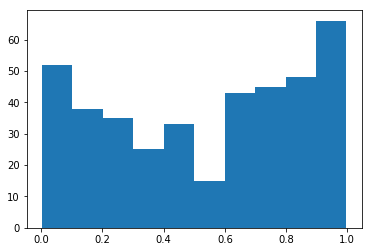

In [44]:
plt.hist(submission_df['label'])

In [45]:
#submission_df.to_csv("submission.csv", index=False)
submission_df.to_csv("submission.csv", index=False)

(array([53., 33., 36., 50., 53., 34., 36., 28., 34., 43.]),
 array([7.05145998e-04, 1.00104663e-01, 1.99504179e-01, 2.98903696e-01,
        3.98303213e-01, 4.97702729e-01, 5.97102246e-01, 6.96501763e-01,
        7.95901279e-01, 8.95300796e-01, 9.94700313e-01]),
 <a list of 10 Patch objects>)

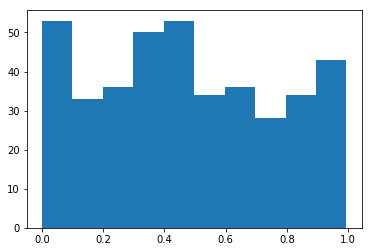

In [46]:
plt.hist(submission_df_resnext['label'])

(array([ 84.,  19.,  18.,  17.,  31.,  10.,  20.,  13.,  19., 169.]),
 array([2.80414533e-04, 1.00251372e-01, 2.00222329e-01, 3.00193286e-01,
        4.00164243e-01, 5.00135200e-01, 6.00106158e-01, 7.00077115e-01,
        8.00048072e-01, 9.00019029e-01, 9.99989986e-01]),
 <a list of 10 Patch objects>)

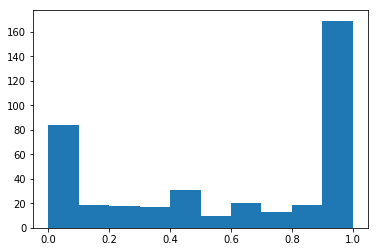

In [47]:
plt.hist(submission_df_xception['label'])